# Imports

In [66]:
import psycopg2 as pg
import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt

from IPython.display       import Image

from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm


In [2]:
# configurações globais
sns.set_theme()                                                   # gráfico
plt.rcParams['figure.figsize'] = [20, 12]                         # gráfico

# 1 Coleta dos Dados

In [19]:
# Credenciais
host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'
username = 'member'
password = 'cdspa'

In [20]:
conn = pg.connect(user = username,
                  password = password,
                  host = host,
                  port = port,
                  database = database)

OperationalError: could not translate host name "comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com" to address: Name or service not known


## 1.1 Consulta do Schema

In [ ]:
cursor = conn.cursor()

query_schema = """
    SELECT nspname
    FROM pg_catalog.pg_namespace
"""

cursor.execute(query_schema)

record = cursor.fetchall()
cursor.close()
conn.close()

In [ ]:
record

## 1.2 Consulta das Tabelas

In [ ]:
cursor = conn.cursor()

query_table = """
select tablename
from pg_catalog.pg_tables pt 
where  schemaname = 'pa004'
"""

cursor.execute(query_table)
record = cursor.fetchall()
print(record)

cursor.close()
conn.close()

## 1.3 Coleta de Dados usando o Psycopg2

In [ ]:
cursor = conn.cursor()

query = """
SELECT
*
FROM pa004.users u
WHERE u.age > 44
LIMIT 10
"""

cursor.execute(query)
record = cursor.fetchall()
print(record)

cursor.close()
conn.close()

In [ ]:
pd.DataFrame(record)

## 1.4 Coleta de Dados usando Pandas

In [ ]:
query = """
SELECT
*
FROM pa004.users u
WHERE u.age > 44
LIMIT 10
"""

pd.read_sql(query, conn)

In [ ]:
query = """
SELECT
*
FROM pa004.users u LEFT JOIN pa004.vehicle v ON (u.id = v.id)
                   LEFT JOIN pa004.insurance i ON (u.id = i.id)
"""

df = pd.read_sql(query, conn)
df.head()

In [ ]:
# Drop das Colunas "id" que estão repetidas
df['id_aux'] = df['id'].apply(np.mean, axis=1)
df = df.drop(columns='id', axis=1)

df.insert(0, 'id', df['id_aux'].astype('int64')) 
df = df.drop(columns='id_aux', axis=1)

In [ ]:
df.head()

In [ ]:
df.to_csv('datasets/data_raw.csv', index=False)

# 2 Análise Descritiva

In [3]:
df2 = pd.read_csv('datasets/data_raw.csv')

In [12]:
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


## 2.1 Dimensões dos dados

In [13]:
print(f'Linhas: {df2.shape[0]}')
print(f'Colunas: {df2.shape[1]}')

Linhas: 381109
Colunas: 12


## 2.2 Tipos das Variáveis

In [14]:
df2.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 2.3 Checagem de NA's

In [15]:
df2.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 2.4 Estatística Descritiva

In [16]:
df2.describe()

,id,age,region_code,policy_sales_channel,driving_license,previously_insured,annual_premium,vintage,response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,26.388807,112.034295,0.997869,0.458210,30564.389581,154.347397,0.122563
std,110016.836208,15.511611,13.229888,54.203995,0.046110,0.498251,17213.155057,83.671304,0.327936
min,1.000000,20.000000,0.000000,1.000000,0.000000,0.000000,2630.000000,10.000000,0.000000
25%,95278.000000,25.000000,15.000000,29.000000,1.000000,0.000000,24405.000000,82.000000,0.000000
50%,190555.000000,36.000000,28.000000,133.000000,1.000000,0.000000,31669.000000,154.000000,0.000000
75%,285832.000000,49.000000,35.000000,152.000000,1.000000,1.000000,39400.000000,227.000000,0.000000
max,381109.000000,85.000000,52.000000,163.000000,1.000000,1.000000,540165.000000,299.000000,1.000000


In [17]:
df2_cat = df2.select_dtypes(include=['object'])
df2_cat.head()

,gender,vehicle_age,vehicle_damage
0,Male,< 1 Year,Yes
1,Female,1-2 Year,No
2,Female,< 1 Year,No
3,Female,< 1 Year,No
4,Male,1-2 Year,Yes


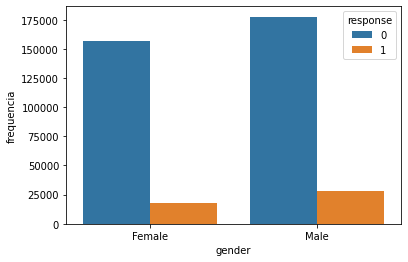

In [18]:
# gender x response
df_aux = df2[['id', 'gender', 'response']].groupby(['gender', 'response']).count().reset_index()
df_aux['frequencia'] = df_aux['id']
sns.barplot(data=df_aux, x='gender', y='frequencia', hue='response');

<AxesSubplot:xlabel='vehicle_age', ylabel='frequencia'>

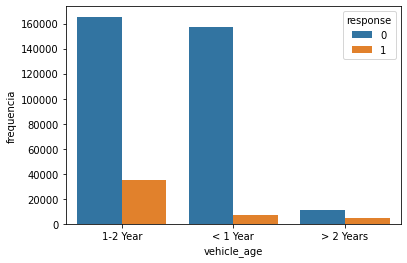

In [19]:
# vehicle_age x response
df_aux = df2[['vehicle_age', 'response', 'id']].groupby(['vehicle_age', 'response']).count().reset_index()
df_aux['frequencia'] = df_aux['id']
sns.barplot(data=df_aux, x='vehicle_age', y='frequencia', hue='response')

<AxesSubplot:xlabel='vehicle_damage', ylabel='frequencia'>

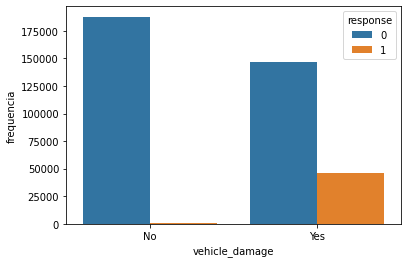

In [20]:
# vehicle_damage x response
df_aux = df2[['vehicle_damage', 'response', 'id']].groupby(['vehicle_damage', 'response']).count().reset_index()
df_aux['frequencia'] = df_aux['id']
sns.barplot(data=df_aux, x='vehicle_damage', y='frequencia',hue='response')

# 3 Feature Engineering

In [4]:
df3 = df2.copy()

## 3.1 Mapa Mental de Hipóteses

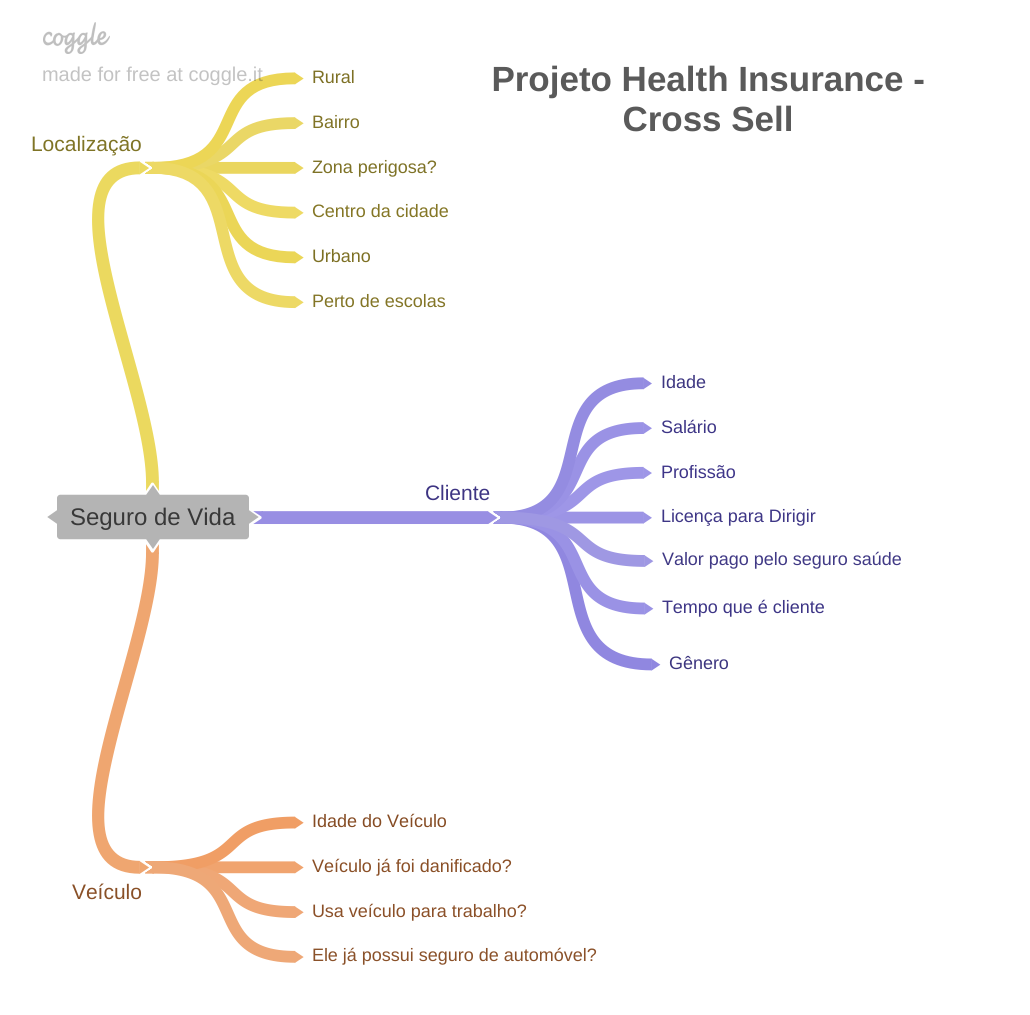

In [22]:
Image('images/Seguro_de_Vida.png')

## 3.2 Criação de Hipóteses

### 3.2.1 Clientes

**H1**: Clientes mais velhos tem mais interesse em obter seguro de automóvel.

**H2**: Clientes mulheres tem mais interesse em obter seguro de automóvel.

**H3**: Clientes com licença para dirigir tem mais interesse em obter seguro de automóvel.

**H4**: Clientes que pagaram mais pelo seguro de vida possuem mais interesse em obter seguro de automóvel.

**H5**: Clientes mais antigos possuem mais interesse em obter seguro de automóivel.

### 3.2.2 Veículo

**H6**: Clientes com veículos mais antigos tem menos interesse em obter seguro de automóvel.

**H7**: Clientes com veículos que já foram danificados tem mais interesse em obter seguro de automóvel.

**H8**: Clientes que já possuem seguro de automóvel em outra seguradora possuem menos interesse em obter seguro de automóvel.

**H9**: Clientes que usam o carro para trabalhar possuem mais interesse em obter seguro de automóvel.

### 3.2.3 Localização

Nesse ciclo não temos grandes informações sobre as localizações dos clientes, então não serão expĺoradas hipóteses de negócios para esse atributo. Mas, algumas hipóteses que poderiam ser levantadas, seriam:

**H10**: Clientes que moram na zona urbana possuem mais interesse em obter seguro de automóvel.

**H11**: Clientes que moram em área periféricas possuem menos interesse em obter seguro de automóvel.

**H12**: Clientes que moram em área perto a escolas possuem mais interesse em obter seguro de automóvel.

## 3.3 Feature Engineering

In [5]:
# gender
df3['gender'] = df3['gender'].apply(lambda x: '0' if x == 'Male' else '1')

# vehicle_age
df3['vehicle_age'] = df3['vehicle_age'].apply(lambda x: 0.5 if x == '< 1 Year' else 
                                                        1.5 if x == '1-2 Year' else
                                                        2.5)

# vehicle damage
df3['vehicle_damage'] = df3['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

In [24]:
df3.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,0,23,11.0,152.0,1,0.5,1,0,23367.0,249,0
1,13,1,41,15.0,14.0,1,1.5,0,1,31409.0,221,0
2,18,1,25,35.0,152.0,1,0.5,0,1,46622.0,299,0
3,31,1,26,8.0,160.0,1,0.5,0,0,2630.0,136,0
4,39,0,45,8.0,124.0,1,1.5,1,0,42297.0,264,0


# 4 Análise Exploratória dos Dados


Referências para gráficos: 
https://www.python-graph-gallery.com/
https://www.python-graph-gallery.com/stacked-and-percent-stacked-barplot

In [6]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Variável Resposta

In [ ]:
df_aux = df4[['id','response']].groupby('response').count().reset_index()

sns.barplot(data=df_aux, x='response', y='id')

### 4.1.2 Variáveis Numéricas

In [ ]:
df4_num = df4.select_dtypes(include=['int64', 'float64'])

df4_num.hist(bins=25);

## 4.2 Análise Bivariada

### 4.2.1 H1: Clientes mais velhos tem mais interesse em obter seguro de automóvel.
Falso. Clientes na meia idade (entre 30 e 50 anos) possuem mais interesse em obter seguro de automóvel.

<AxesSubplot:xlabel='age', ylabel='response'>

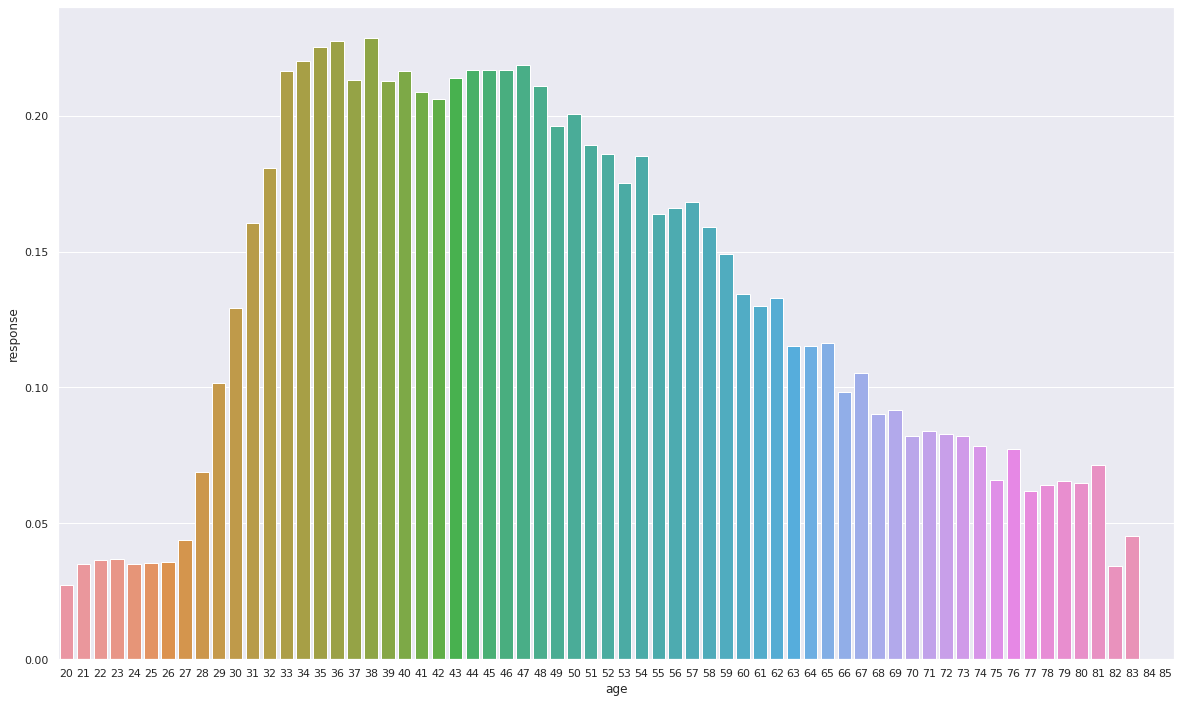

In [25]:
# age x response
df_aux = df4[['age', 'response']].groupby('age').mean().reset_index()

sns.barplot(data=df_aux, x='age', y='response')

### 4.2.2 H2: Clientes mulheres tem mais interesse em obter seguro de automóvel.
Falso. Clientes mulheres tem menos interesse em obter seguro de automóvel.

<AxesSubplot:xlabel='gender', ylabel='response'>

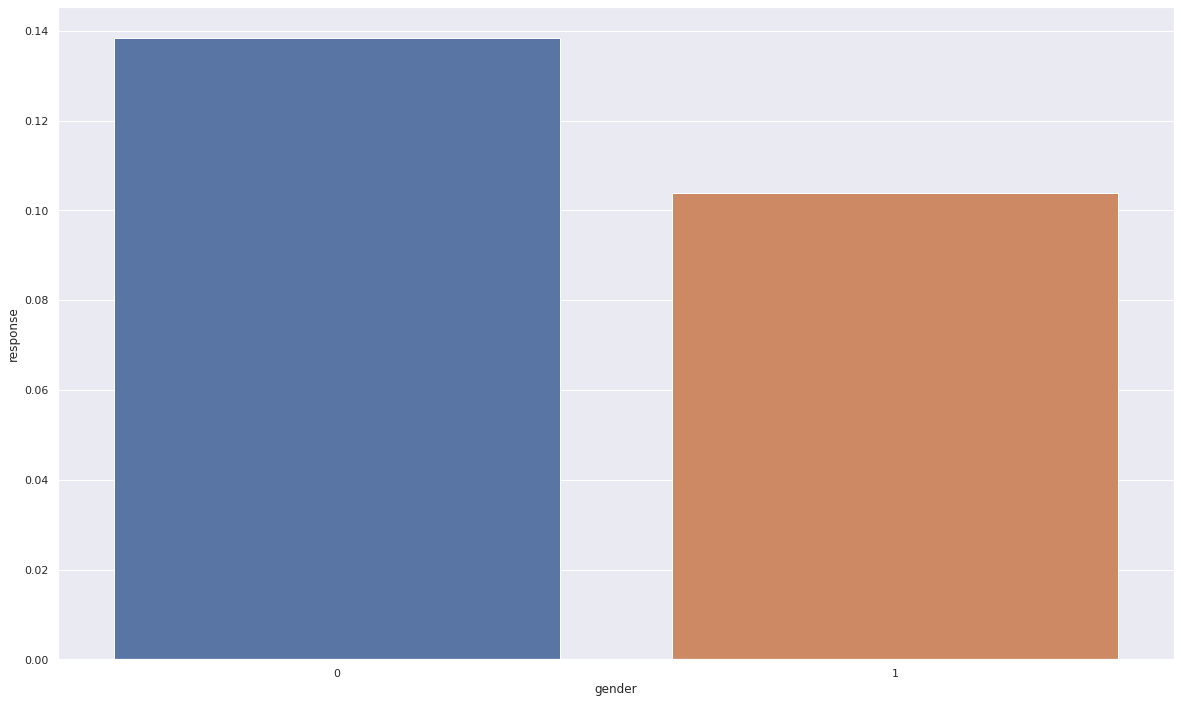

In [24]:
# gender x response
df_aux = df4[['gender', 'response']].groupby('gender').mean().reset_index()

sns.barplot(data=df_aux, x='gender', y='response')

### 4.2.3 H3: Clientes com licença para dirigir tem mais interesse em obter seguro de automóvel.
Verdadeiro. Clientes com licença para dirigir tem mais interesse em obter seguro de automóvel.

<AxesSubplot:xlabel='driving_license', ylabel='response'>

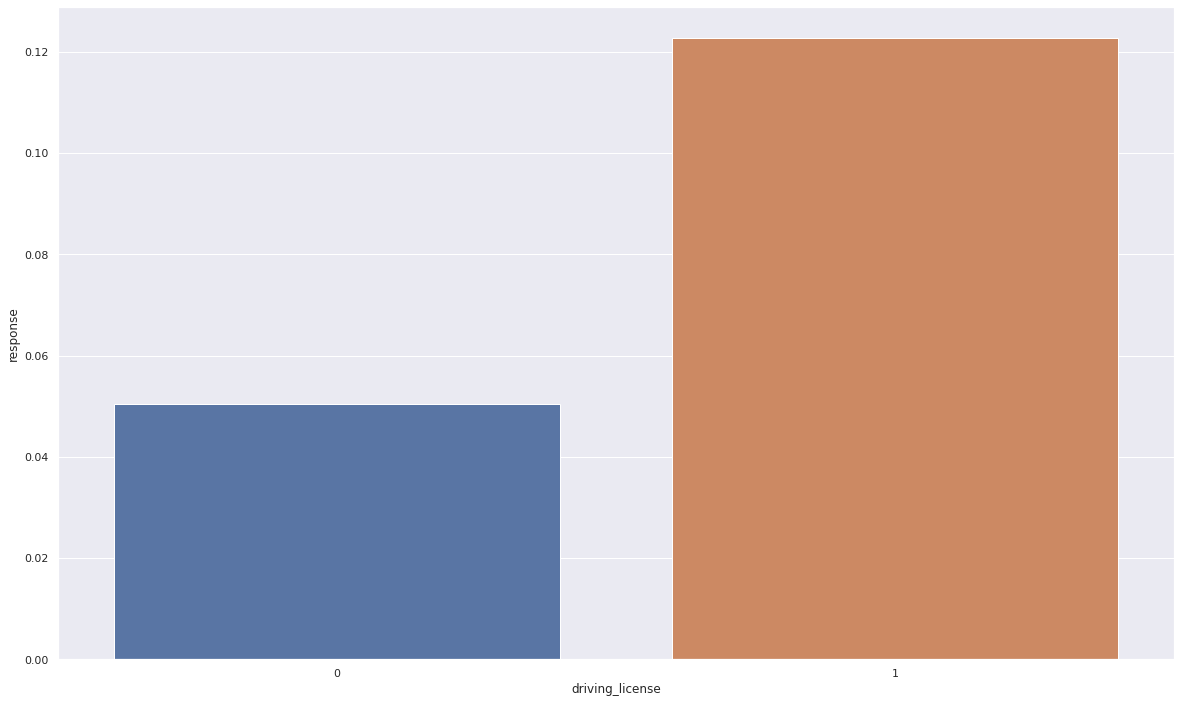

In [23]:
# driving_license x response
df_aux = df4[['driving_license', 'response']].groupby('driving_license').mean().reset_index()

sns.barplot(data=df_aux, x='driving_license', y='response')

### 4.2.4 H4: Clientes que pagaram mais pelo seguro de vida possuem mais interesse em obter seguro de automóvel.

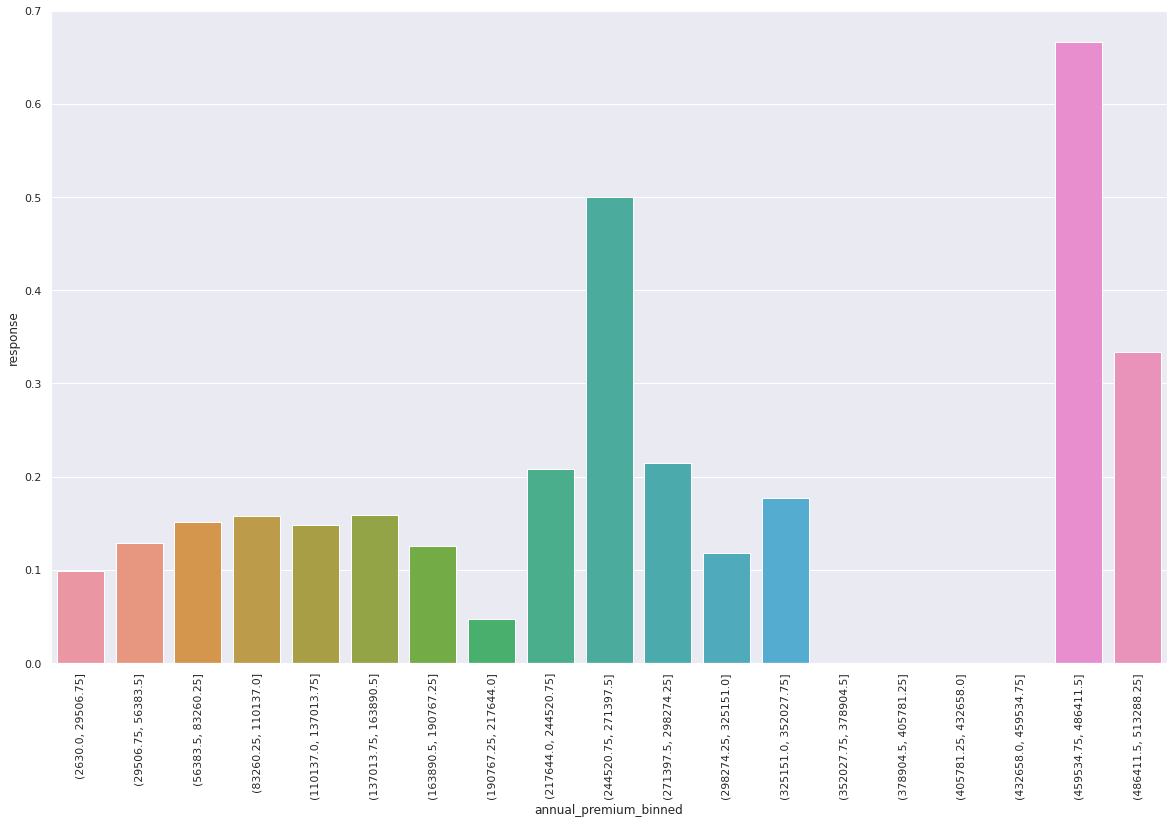

In [22]:
# annual_premium x response
# df_aux = df4[['annual_premium', 'response']].groupby('annual_premium').count().reset_index()

x0 = df4['annual_premium'].min()
xf = df4['annual_premium'].max()

b = list(np.arange(x0, xf, (xf-x0)/20))
df4['annual_premium_binned'] = pd.cut(df4['annual_premium'], bins=b)
df_aux = df4[['annual_premium_binned', 'response']].groupby('annual_premium_binned').mean().reset_index()

sns.barplot(data=df_aux, x='annual_premium_binned', y='response');
plt.xticks(rotation=90);

### 4.2.5 H5: Clientes mais antigos possuem mais interesse em obter seguro de automóvel.
**Falso** Não há diferença significativa com relação ao tempo que o cliente possui o seguro de vida.

<AxesSubplot:xlabel='response', ylabel='vintage_binned'>

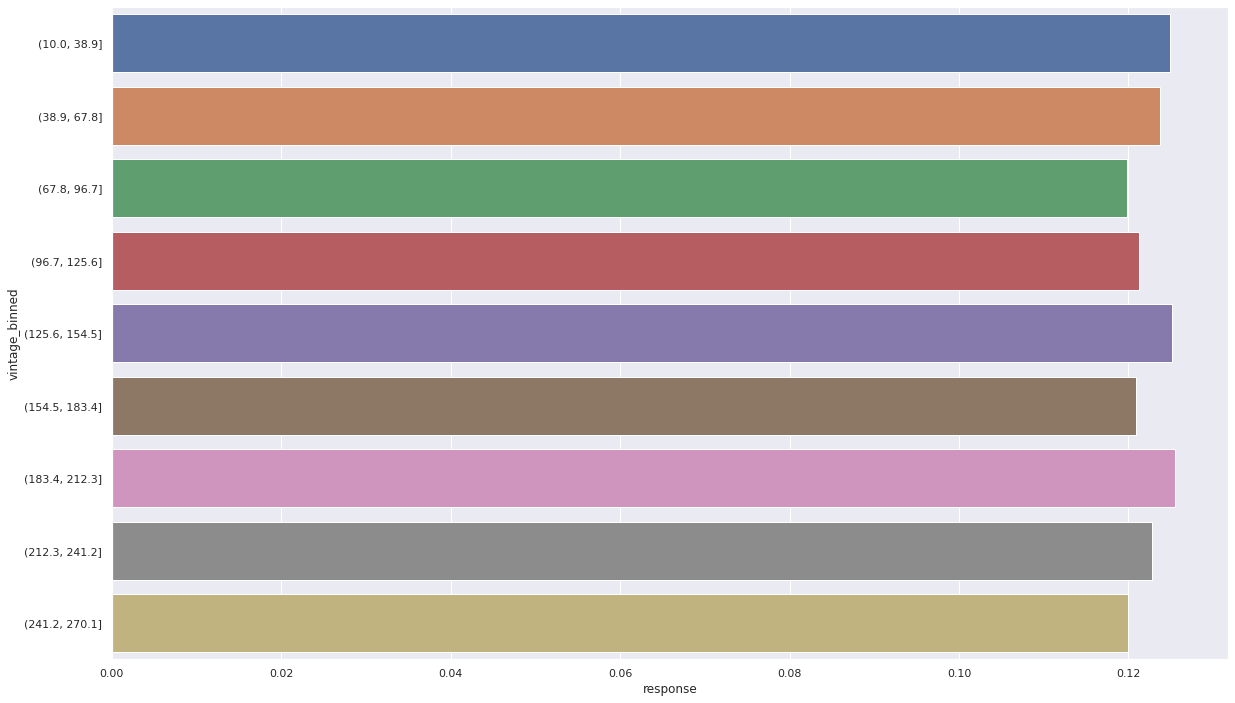

In [39]:
# vintage x response

x0 = df4['vintage'].min()
xf = df4['vintage'].max()

b = list(np.arange(x0, xf, (xf-x0)/10))
df4['vintage_binned'] = pd.cut(df4['vintage'], b)
aux = df4[['vintage_binned', 'response']].groupby('vintage_binned').mean().reset_index()

sns.barplot(data=aux, y='vintage_binned', x='response')


### 4.2.6 H6: Clientes com veículos mais antigos tem menos interesse em obter seguro de automóvel.
**Falso** Clientes com veículos mais antigos tem mais interesse em obter seguro de automóvel

<AxesSubplot:xlabel='vehicle_age', ylabel='response'>

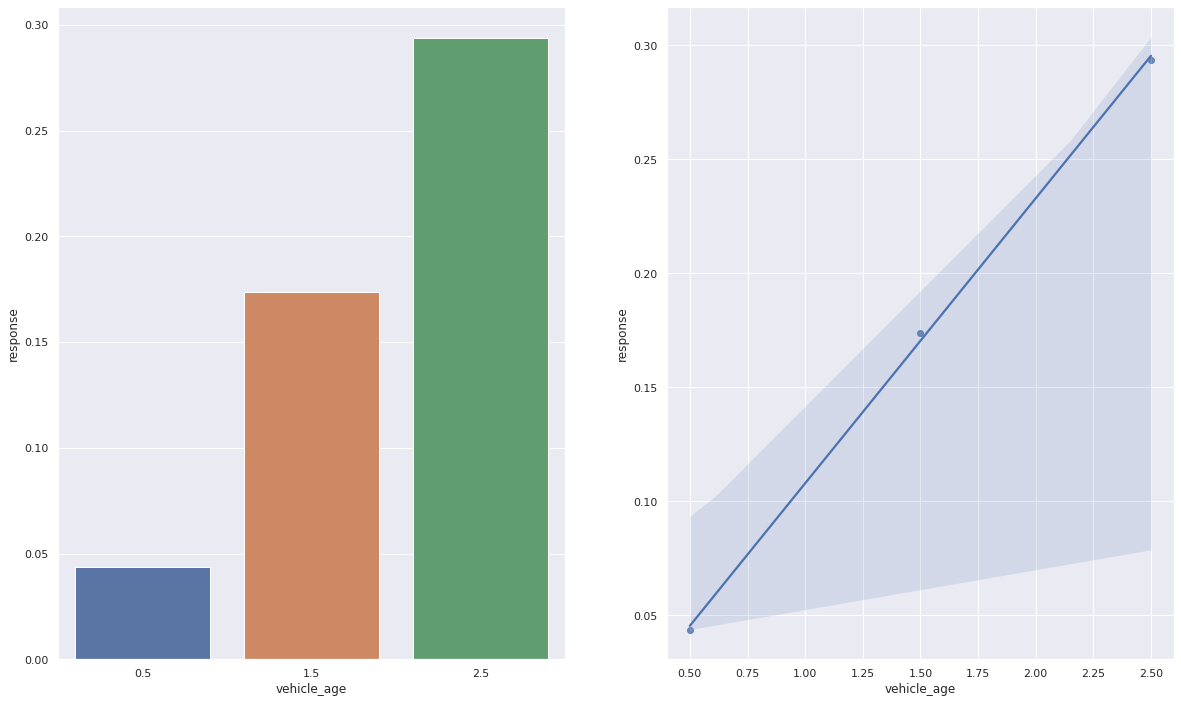

In [41]:
# vehicle_age x response
aux = df4[['vehicle_age', 'response']].groupby('vehicle_age').mean().reset_index()

plt.subplot(1, 2, 1)
sns.barplot(data=aux, x='vehicle_age', y='response')

plt.subplot(1, 2, 2)
sns.regplot(data=aux, x='vehicle_age', y='response')

### 4.2.7 H7: Clientes com veículos que já foram danificados tem mais interesse em obter seguro de automóvel.
**Verdade** Clientes com veículos que já foram danificados tem MUITO mais interesse em obter seguro de automóvel.


<AxesSubplot:xlabel='vehicle_damage', ylabel='response'>

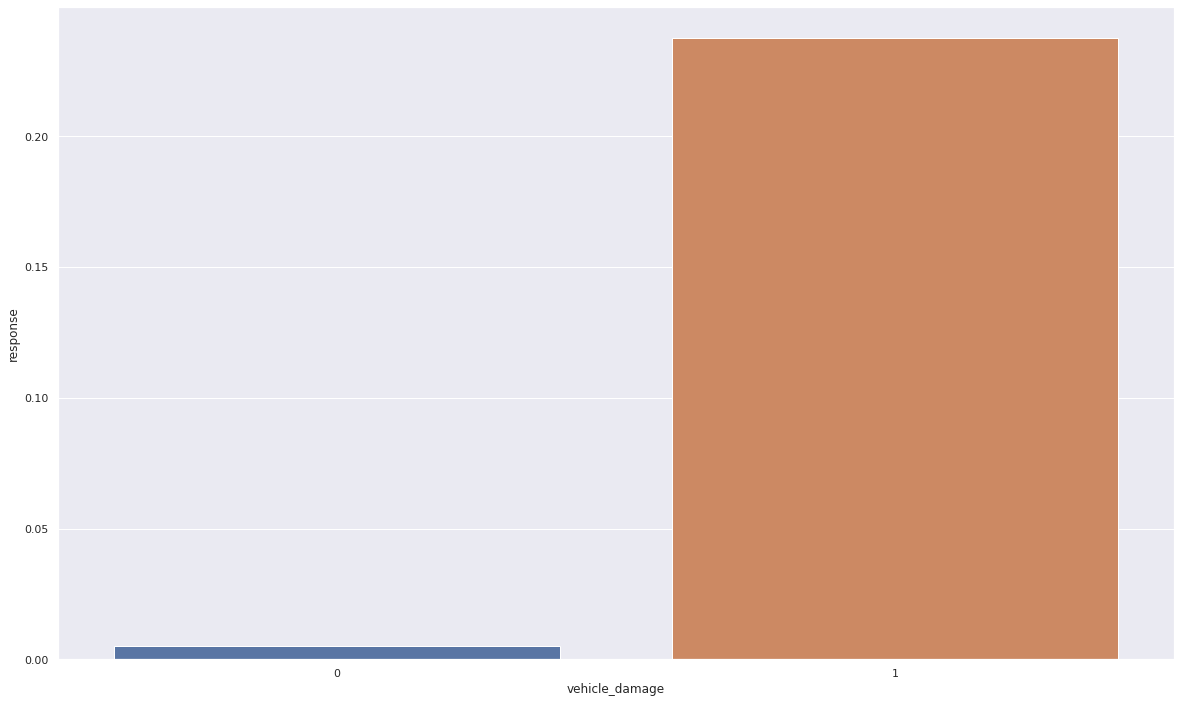

In [47]:
# vehicle_damage x response
aux = df4[['vehicle_damage', 'response']].groupby('vehicle_damage').mean().reset_index()

sns.barplot(data=aux, x='vehicle_damage', y='response')

### 4.2.8 H8: Clientes que já possuem seguro de automóvel em outra seguradora possuem menos interesse em obter seguro de automóvel.
**Verdade** Clientes que já possuem seguro de automóvel em outra seguradora possuem EXTREMAMENTE MENOS interesse em obter um novo seguro.

<AxesSubplot:xlabel='previously_insured', ylabel='response'>

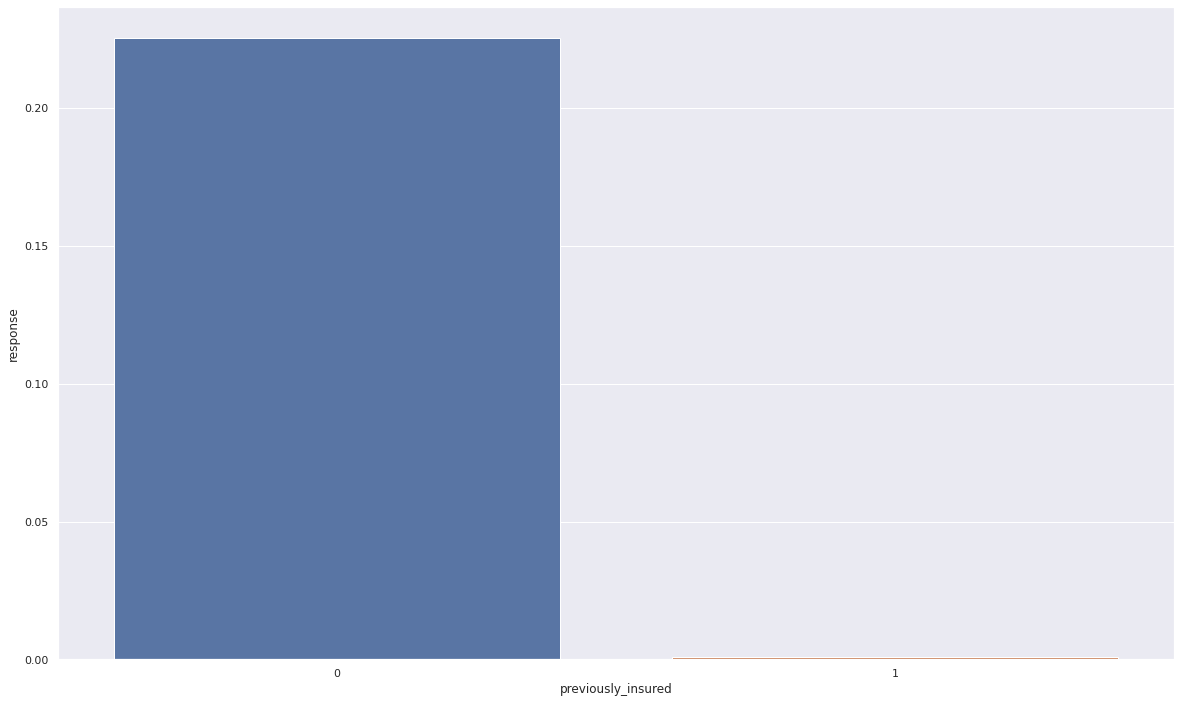

In [50]:
# previously_insured x response
aux = df4[['previously_insured', 'response']].groupby('previously_insured').mean().reset_index()

sns.barplot(data=aux, x='previously_insured', y='response')

# 5 Preparação dos Dados

In [34]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

df5 = pd.concat([X_train, y_train], axis=1)

## 5.1 Padronização

In [35]:
ss = pp.StandardScaler() 

# annual_premium (pois a distribuição é próxima da normal. Não estamos tratando os outliers)
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)

## 5.2 Rescaling

In [36]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age (pois a distribuição não é próxima da normal)
df5['age'] = mms_age.fit_transform(df5[['age']].values)

# vintage (pois a distribuição não é próxima da normal)
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values) 


## 5.3 Enconder

In [37]:
# region_code - Target Encoding (escolhido) / Frequency Encoding / Weight Target Encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5['region_code'] = df5['region_code'].map(target_encode_region_code)

# vehicle_damage -  One Hot Encoding (escolhido) / Frequency Encoding / Target Encoding / Weight Target Encoding
# df5 = pd.get_dummies(df5, prefix='vehicle_damage', columns=['vehicle_damage'])

# policy_sales_channel - Frequency Encoding / One Hot Encoding / Target Encoding / Weight Target Encoding
fe_encode_policy = df5.groupby('policy_sales_channel').size() / len(df5)
df5['policy_sales_channel'] = df5['policy_sales_channel'].map(fe_encode_policy)


In [38]:
df5.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
332803,374686,0,0.138462,0.061162,0.352554,1,0.5,0,1,1.534261,0.612457,0
116248,165999,0,0.061538,0.079791,0.352554,1,0.5,0,1,-0.054806,0.432526,0
255005,132267,0,0.200000,0.102644,0.209927,1,1.5,0,1,0.931260,0.311419,0
317474,250655,0,0.015385,0.096875,0.352554,1,0.5,1,0,0.391561,0.401384,0
344212,85041,1,0.046154,0.071809,0.209927,1,0.5,1,0,0.112379,0.235294,0


## 5.4 Validação da Preparação

In [39]:
# annual premium
X_test['annual_premium'] = ss.transform(X_test[['annual_premium']].values)

# age
X_test['age'] = mms_age.transform(X_test[['age']].values)

# vintage 
X_test['vintage'] = mms_vintage.transform(X_test[['vintage']].values)

# region_code
X_test['region_code'] = X_test['region_code'].map(target_encode_region_code)

# vehicle_damage
# X_test = pd.get_dummies(X_test, prefix='vehicle_damage', columns=['vehicle_damage'])

# policy_sales_channel
X_test['policy_sales_channel'] = X_test['policy_sales_channel'].map(fe_encode_policy)

X_test = X_test.fillna(0)

# X_test.head()

In [40]:
X_test.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
dtype: int64

# 6 Seleção dos Atributos

In [41]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=42, n_jobs=-1)

# data preparation
X_train_n = df5.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(X_train_n, y_train_n)


ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=42)

Feature ranking:
                feature  importance
0               vintage    0.278736
0        annual_premium    0.248130
0                   age    0.157828
0           region_code    0.103604
0        vehicle_damage    0.075087
0  policy_sales_channel    0.060949
0    previously_insured    0.052345
0           vehicle_age    0.017401
0                gender    0.005431
0       driving_license    0.000488


ValueError: The number of FixedLocator locations (11), usually from a call to set_ticks, does not match the number of ticklabels (10).

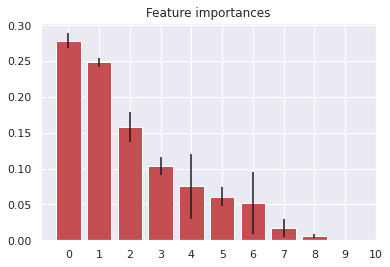

In [42]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# print the feature ranking
print('Feature ranking:')
df = pd.DataFrame()
for i,j in zip(X_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

# plot the imputity-based feature importances of the forest
plt.figure()
plt.title('Feature importances')
plt.bar(range(X_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train_n.shape[1]])
plt.show()

# 7 Machine Learning

In [44]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

X_train = df5[cols_selected]
X_test = X_test[cols_selected]

## 7.1 KNN

In [63]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model_training
knn_model.fit(X_train, y_train)

# model prediction - Poder de Generalização
yhat_knn = knn_model.predict_proba(X_test)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

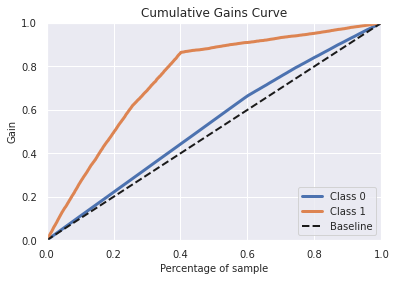

In [64]:
# ganho acumulado
skplt.metrics.plot_cumulative_gain(y_test, yhat_knn)

## 7.2 Regressão Logística

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

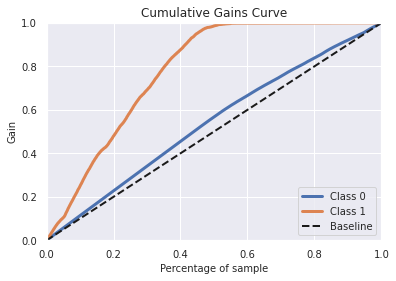

In [69]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit(X_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(X_test)

# ganho acumulado
skplt.metrics.plot_cumulative_gain(y_test, yhat_lr)